In [1]:
import sympy as sp
sp.init_printing()
import numpy as np
from pynoa import *

# A. Notation
The quadrotor model derived in this Notebook is adopted from Ko et al. due to their experimentally-proven VDM-aided inertial navigation and the use of quaternion orientation. 
However, the mathematical notations are adopted from Wüest et al. and Böhm et al. due to their clear representation of reference frames.
These reference frames are written in subscript with the following notations:
* $W$ represents the fixed world frame,
* $B$ represents the quadrotor's body center frame,
* $M$ represents the quadrotor's center of mass (CoM) frame, and
* $R_i$ represents the $i$-th rotor center frame.

The $B$ reference frame also coincides with the IMU sensor reference frame. 

# B. State Vector
Symbolic trajectory state vector variables
\begin{equation}
\mathbf{x}_T = \begin{bmatrix} 
	   {{_W}\mathbf{r}_{WB}^\top} &
	   {{_W}\mathbf{v}_{WB}^\top} &
	   {\mathbf{q}_{WB}^\top} &
	   {{_B}\boldsymbol{\omega}_{WB}^\top}
	\end{bmatrix}^\top
	\in \mathbb{R}^{13 \times 1}
\end{equation}

In [2]:
# Position state
r_W_WB_x, r_W_WB_y, r_W_WB_z = sp.symbols("{_W{r}_{WB_x}}, {_W{r}_{WB_y}}, {_W{r}_{WB_z}}")
r_W_WB = sp.Matrix([[r_W_WB_x , r_W_WB_y , r_W_WB_z]]).T

# Velocity state
v_W_WB_x , v_W_WB_y , v_W_WB_z = sp.symbols("{_W{v}_{WB_x}}, {_W{v}_{WB_y}}, {_W{v}_{WB_z}}")
v_W_WB = sp.Matrix([[v_W_WB_x , v_W_WB_y , v_W_WB_z]]).T

# Quaternion attitude state
q_WB_w, q_WB_x, q_WB_y, q_WB_z = sp.symbols("q_{WB_w}, q_{WB_x}, q_{WB_y}, q_{WB_z}")
q_WB = sp.Matrix([[q_WB_w, q_WB_x, q_WB_y, q_WB_z]]).T
R_WB = quat2rotm_sym(q_WB) # rotation matrix equivalent of quaternion

# Angular velocity state
omega_B_WB_x, omega_B_WB_y, omega_B_WB_z = sp.symbols("{_B{\omega}_{WB_x}}, {_B{\omega}_{WB_y}}, {_B{\omega}_{WB_z}}")
omega_B_WB = sp.Matrix([[omega_B_WB_x, omega_B_WB_y, omega_B_WB_z]]).T

# Equation (2): trajectory state vector
x_T = sp.Matrix([r_W_WB, v_W_WB, q_WB, omega_B_WB])

Symbolic inertial parameters state vector

\begin{equation}
	\mathbf{x}_I=
		\begin{bmatrix} 
		   m &
		   {{_M}\boldsymbol{i}^\top} &
		   {{_W}\boldsymbol{g}^\top}
		\end{bmatrix}^\top
		\in \mathbb{R}^{7 \times 1}
\end{equation}

In [3]:
m, i_M_xx, i_M_yy, i_M_zz = sp.symbols("m, {_M{i}_{xx}}, {_M{i}_{yy}}, {_M{i}_{zz}}")

# Moment of inertia
i_M = sp.Matrix([[i_M_xx, i_M_yy, i_M_zz]]).T
I_M = sp.diag(i_M_xx, i_M_yy, i_M_zz)

# Earth's gravitational acceleration
g_W_x, g_W_y, g_W_z = sp.symbols("{_W{g}_x}, {_W{g}_y}, {_W{g}_z}")
g_W = sp.Matrix([[g_W_x, g_W_y, g_W_z]]).T

# Equation (3): inertial parameters state vector
x_I = sp.Matrix([m, i_M, g_W])

Symbolic rotor parameters

\begin{equation}
	\mathbf{x}_G=
		\begin{bmatrix} 
		   {\lambda}_l &
		   {\boldsymbol{d}_{ij}^\top} &
		   {k_{f_i}^\top} &
		   {k_{m_i}^\top}
		\end{bmatrix}^\top
		\in \mathbb{R}^{13 \times 1}
\end{equation}

In [4]:
# Drag coefficient
lambda_l = sp.symbols("{\lambda}_l")

# Distance from the body frame B to the line connecting the center of the propellers i and j
d_12, d_23, d_34, d_14 = sp.symbols("d_{12}, d_{23}, d_{34}, d_{14}")

# Rotor thrust force coefficients
k_f_1, k_f_2, k_f_3, k_f_4 = sp.symbols("k_{f_1} k_{f_2} k_{f_3} k_{f_4}")

# Rotor body torque coefficients
k_m_1, k_m_2, k_m_3, k_m_4 = sp.symbols("k_{m_1} k_{m_2} k_{m_3} k_{m_4}")

# Equation (4): rotor parameters state vector
x_G = sp.Matrix([[lambda_l, d_12, d_23, d_34, d_14,
                    k_f_1, k_f_2, k_f_3, k_f_4,
                    k_m_1, k_m_2, k_m_3, k_m_4
                ]]).T

r_B_BR_1 = sp.Matrix([[d_12, -d_14, 0]]).T
r_B_BR_2 = sp.Matrix([[d_12, d_23, 0]]).T
r_B_BR_3 = sp.Matrix([[-d_34, d_23, 0]]).T
r_B_BR_4 = sp.Matrix([[-d_34, -d_14, 0]]).T

Control inputs

$\mathbf{u}=\begin{bmatrix}
	u_1 & u_2 & u_3 & u_4	
\end{bmatrix}^\top = \begin{bmatrix}
	\omega_1 & \omega_2 & \omega_3 & \omega_4	
\end{bmatrix}^\top$

In [5]:
omega_1, omega_2, omega_3, omega_4 = sp.symbols("{\omega}_1, {\omega}_2, {\omega}_3, {\omega}_4")
u = sp.Matrix([[omega_1, omega_2, omega_3, omega_4]]).T

# C. Process Model $\dot{x} = f(x,u)$
Equivalent control-affine equations for linear acceleration $\dot{v}$ and angular acceleration $\dot{\omega}$

In [6]:
# Projection matrix in x & y axes
P_xy = sp.diag(1,1,0)

# z-axis unit vector
e_z = sp.Matrix([[0,0,1]]).T

# Linear acceleration control input vector field
k_v_dot_1 = 1/m*R_WB*k_f_1*e_z - lambda_l/m*R_WB*P_xy*R_WB.T*v_W_WB
k_v_dot_2 = 1/m*R_WB*k_f_2*e_z - lambda_l/m*R_WB*P_xy*R_WB.T*v_W_WB
k_v_dot_3 = 1/m*R_WB*k_f_3*e_z - lambda_l/m*R_WB*P_xy*R_WB.T*v_W_WB
k_v_dot_4 = 1/m*R_WB*k_f_4*e_z - lambda_l/m*R_WB*P_xy*R_WB.T*v_W_WB

# Angular acceleration control input vector field
k_omega_dot_1 = I_M.inv()*(k_m_1*e_z + r_B_BR_1.cross(k_f_1*e_z))
k_omega_dot_2 = I_M.inv()*(k_m_2*e_z + r_B_BR_2.cross(k_f_2*e_z))
k_omega_dot_3 = I_M.inv()*(k_m_3*e_z + r_B_BR_3.cross(k_f_3*e_z))
k_omega_dot_4 = I_M.inv()*(k_m_4*e_z + r_B_BR_4.cross(k_f_4*e_z))

# k_omega_dot_1 = sp.Matrix([[-1/i_M_xx*d_14*k_f_1, -1/i_M_yy*d_12*k_f_1, -1/i_M_zz*k_m_1]]).T
# k_omega_dot_2 = sp.Matrix([[ 1/i_M_xx*d_23*k_f_2, -1/i_M_yy*d_12*k_f_2,  1/i_M_zz*k_m_2]]).T
# k_omega_dot_3 = sp.Matrix([[ 1/i_M_xx*d_23*k_f_3,  1/i_M_yy*d_34*k_f_3, -1/i_M_zz*k_m_3]]).T
# k_omega_dot_4 = sp.Matrix([[-1/i_M_xx*d_14*k_f_4,  1/i_M_yy*d_34*k_f_4,  1/i_M_zz*k_m_4]]).T


Control-affine vector fields of process model 
* $f_0$ : drift vector field
* $f_i$ where $i=1,2,3,4$ : control input vector fields

In [7]:
f0 = sp.Matrix([v_W_WB, 
                g_W,
                1/2*quatprod_sym(q_WB, sp.Matrix([0, omega_B_WB])),
                -I_M.inv()*(omega_B_WB.cross(I_M*omega_B_WB))])
                
# inputs: u_i = (omega_i)^2 and (omega_i) ; i=1,2,3,4
f1 = sp.Matrix([sp.zeros(3,1), k_v_dot_1, sp.zeros(4,1), k_omega_dot_1])
f2 = sp.Matrix([sp.zeros(3,1), k_v_dot_2, sp.zeros(4,1), k_omega_dot_2])
f3 = sp.Matrix([sp.zeros(3,1), k_v_dot_3, sp.zeros(4,1), k_omega_dot_3])
f4 = sp.Matrix([sp.zeros(3,1), k_v_dot_4, sp.zeros(4,1), k_omega_dot_4])

/home/bagaskarapp/.local/lib/python3.6/site-packages/sympy/matrices/repmatrix.py:102: SymPyDeprecationWarning: 

non-Expr objects in a Matrix has been deprecated since SymPy 1.9. Use
list of lists, TableForm or some other data structure instead. See
https://github.com/sympy/sympy/issues/21497 for more info.

  deprecated_since_version="1.9"


# D. Measurement Model

In [8]:
k_l = lambda_l*(omega_1+omega_2+omega_3+omega_4)

# drag force ratio matrix
V = sp.diag(-k_l, -k_l, 0)

# Rotor thrust & drag forces
F_B_thrust = (k_f_1*omega_1**2 + k_f_2*omega_2**2 + k_f_3*omega_3**2 + k_f_4*omega_4**2)*e_z
F_B_drag = V*R_WB.T*v_W_WB

# Inertial measurement unit (IMU) measurement model
h_IMU = sp.Matrix([1/m*(F_B_thrust + F_B_drag), omega_B_WB])

# Barometric altimeter measurement model
h_baro = r_W_WB_z

# Global navigation satelite system (GNSS) measurement model
h_GNSS = sp.Matrix([r_W_WB_x, r_W_WB_y])

# # Unit quaternion
# h_unit = sp.Matrix([q_WB.T*q_WB])

# IMU & Barometric Altimeter Inertial Navigation (IN) Configuration

In [9]:
imu_baro_IN = NOA("IMU & Barometric Altimeter Inertial Navigation")
imu_baro_IN.x = x_T
imu_baro_IN.f = [f0, f1, f2, f3, f4]
imu_baro_IN.h = sp.Matrix([h_IMU, h_baro])

IMU & Barometric Altimeter Inertial Navigation NOA object initialized


Observability rank criterion

In [10]:
imu_baro_IN.LD_order = 2
imu_baro_IN.rank_calc_opt = "numeric"
imu_baro_IN.combn_permn_opt = "drift2ndOrder"
imu_baro_IN.params_config_subs = sp.Matrix([x_T, x_G, x_I, u])
imu_baro_IN.ORC()

Drift 2nd Order Vector Fields
[(0,), (1,), (2,), (3,), (4,)]
current Lie derivative:  k1f0
current Lie derivative:  k1f1
current Lie derivative:  k1f2
current Lie derivative:  k1f3
current Lie derivative:  k1f4
[(0, 1), (0, 2), (0, 3), (0, 4)]
current Lie derivative:  k2f0f1
current Lie derivative:  k2f0f2
current Lie derivative:  k2f0f3
current Lie derivative:  k2f0f4
Substituted parameters with values from same-order prime numbers
printing self.numeric_params_dict:
{{_W{r}_{WB_x}}: 7.9, {_W{r}_{WB_y}}: 2.0, {_W{r}_{WB_z}}: 2.3, {_W{v}_{WB_x}}: 1.9, {_W{v}_{WB_y}}: 1.49, {_W{v}_{WB_z}}: 1.03, q_{WB_w}: 1.7, q_{WB_x}: 6.7, q_{WB_y}: 7.0, q_{WB_z}: 1.07, {_B{\omega}_{WB_x}}: 8.3, {_B{\omega}_{WB_y}}: 1.39, {_B{\omega}_{WB_z}}: 8.9, {\lambda}_l: 6.1, d_{12}: 3.7, d_{23}: 1.3, d_{34}: 2.9, d_{14}: 4.1, k_{f_1}: 4.3, k_{f_2}: 9.7, k_{f_3}: 5.0, k_{f_4}: 5.3, k_{m_1}: 1.27, k_{m_2}: 4.7, k_{m_3}: 7.3, k_{m_4}: 3.0, m: 1.57, {_M{i}_{xx}}: 3.1, {_M{i}_{yy}}: 7.1, {_M{i}_{zz}}: 1.51, {_W{g}_x}

The observable modes are g(x) which satisfiy these partial differential equations (PDE): 


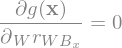

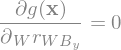

Observable states: 


Unobservable states: 


In [11]:
imu_baro_IN.null_calc_opt = "numeric"
imu_baro_IN.observable_mode()

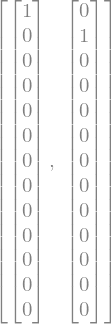

In [12]:
imu_baro_IN.cont_symm

# IMU, GNSS, & Barometric Altimeter Parameter Estimation (PE) Configuration

In [13]:
# Parameter Estimation Configuration. Parameters treated as state variables
imu_gnss_baro_PE = NOA("IMU, GNSS, & Barometric Altimeter Parameter Estimation")
imu_gnss_baro_PE.x = sp.Matrix([x_T, x_I, x_G])

IMU, GNSS, & Barometric Altimeter Parameter Estimation NOA object initialized


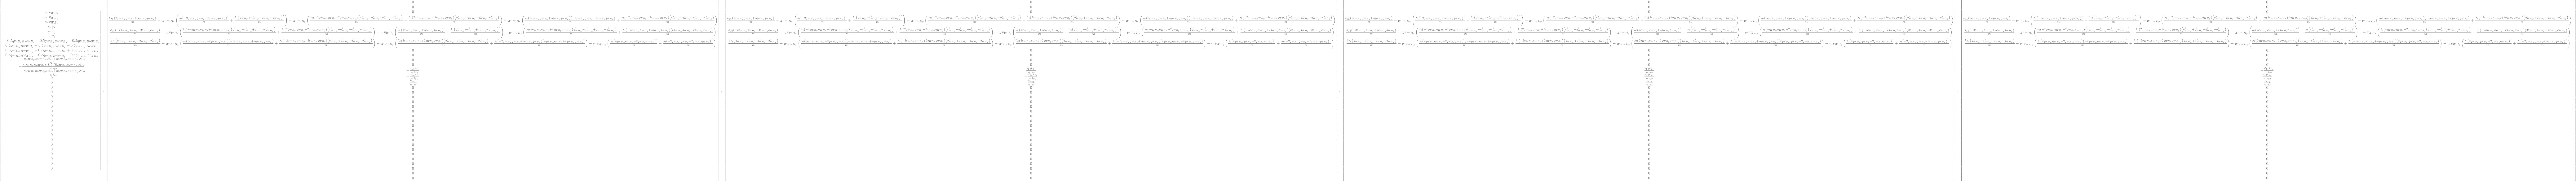

In [14]:
imu_gnss_baro_PE.f = imu_baro_IN.f
for i in range(len(imu_baro_IN.f)):
    imu_gnss_baro_PE.f[i] = sp.Matrix([imu_baro_IN.f[i], sp.zeros(imu_gnss_baro_PE.x.rows - imu_baro_IN.f[i].rows, 1)])
imu_gnss_baro_PE.f

In [15]:
imu_gnss_baro_PE.h = imu_baro_IN.h

In [16]:
imu_gnss_baro_PE.LD_order = 2
imu_gnss_baro_PE.rank_calc_opt = "numeric"
imu_gnss_baro_PE.combn_permn_opt = "drift2ndOrder"
imu_gnss_baro_PE.params_config_subs = sp.Matrix([x_T, x_G, x_I, u])
imu_gnss_baro_PE.ORC()

Drift 2nd Order Vector Fields
[(0,), (1,), (2,), (3,), (4,)]
current Lie derivative:  k1f0
current Lie derivative:  k1f1
current Lie derivative:  k1f2
current Lie derivative:  k1f3
current Lie derivative:  k1f4
[(0, 1), (0, 2), (0, 3), (0, 4)]
current Lie derivative:  k2f0f1
current Lie derivative:  k2f0f2
current Lie derivative:  k2f0f3
current Lie derivative:  k2f0f4
Substituted parameters with values from same-order prime numbers
printing self.numeric_params_dict:
{{_W{r}_{WB_x}}: 5.3, {_W{r}_{WB_y}}: 8.9, {_W{r}_{WB_z}}: 4.3, {_W{v}_{WB_x}}: 1.31, {_W{v}_{WB_y}}: 5.9, {_W{v}_{WB_z}}: 4.7, q_{WB_w}: 1.9, q_{WB_x}: 2.3, q_{WB_y}: 7.0, q_{WB_z}: 6.1, {_B{\omega}_{WB_x}}: 1.27, {_B{\omega}_{WB_y}}: 1.01, {_B{\omega}_{WB_z}}: 5.0, {\lambda}_l: 8.3, d_{12}: 1.1, d_{23}: 4.1, d_{34}: 2.0, d_{14}: 7.9, k_{f_1}: 1.13, k_{f_2}: 1.57, k_{f_3}: 9.7, k_{f_4}: 1.49, k_{m_1}: 1.39, k_{m_2}: 1.51, k_{m_3}: 1.7, k_{m_4}: 3.1, m: 3.7, {_M{i}_{xx}}: 1.3, {_M{i}_{yy}}: 3.0, {_M{i}_{zz}}: 7.3, {_W{g}_x

The observable modes are g(x) which satisfiy these partial differential equations (PDE): 


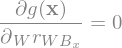

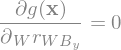

Observable states: 


Unobservable states: 


In [17]:
imu_gnss_baro_PE.null_calc_opt = "numeric"
imu_gnss_baro_PE.observable_mode()

# Barometric Altimeter & GNSS Parameter Estimation (PE) Configuration

In [18]:
baro_GNSS_PE = NOA("Barometric Altimeter & GNSS Parameter Estimation")
baro_GNSS_PE.x = sp.Matrix([x_T, x_I, x_G])

Barometric Altimeter & GNSS Parameter Estimation NOA object initialized


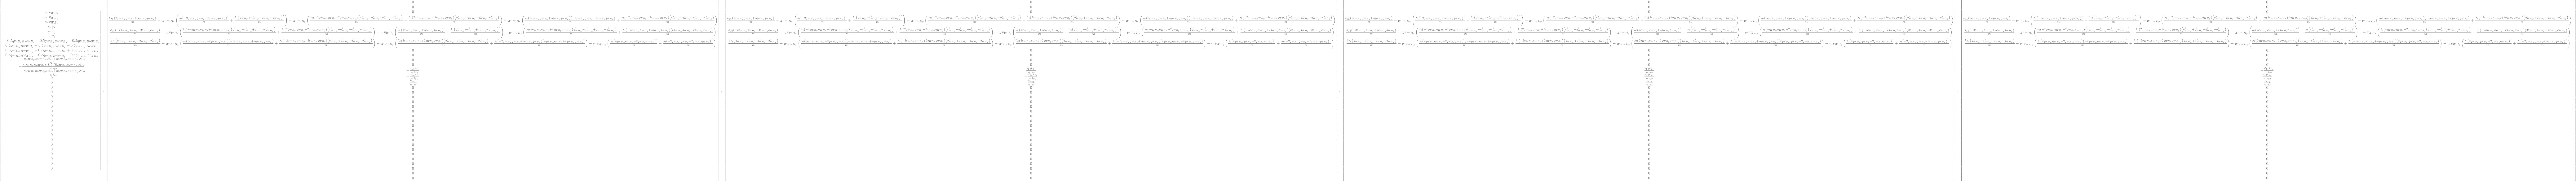

In [19]:
baro_GNSS_PE.f = imu_gnss_baro_PE.f
baro_GNSS_PE.f

In [20]:
baro_GNSS_PE.h = sp.Matrix([h_baro, h_GNSS])

In [21]:
baro_GNSS_PE.LD_order = 2
baro_GNSS_PE.rank_calc_opt = "numeric"
baro_GNSS_PE.combn_permn_opt = "drift2ndOrder"
baro_GNSS_PE.params_config_subs = sp.Matrix([x_T, x_G, x_I, u])
baro_GNSS_PE.ORC()

Drift 2nd Order Vector Fields
[(0,), (1,), (2,), (3,), (4,)]
current Lie derivative:  k1f0
current Lie derivative:  k1f1
k1f1  not included in observability matrix due to null vector
current Lie derivative:  k1f2
k1f2  not included in observability matrix due to null vector
current Lie derivative:  k1f3
k1f3  not included in observability matrix due to null vector
current Lie derivative:  k1f4
k1f4  not included in observability matrix due to null vector
[(0, 1), (0, 2), (0, 3), (0, 4)]
current Lie derivative:  k2f0f1
current Lie derivative:  k2f0f2
current Lie derivative:  k2f0f3
current Lie derivative:  k2f0f4
Substituted parameters with values from same-order prime numbers
printing self.numeric_params_dict:
{{_W{r}_{WB_x}}: 1.13, {_W{r}_{WB_y}}: 7.1, {_W{r}_{WB_z}}: 4.3, {_W{v}_{WB_x}}: 7.3, {_W{v}_{WB_y}}: 1.39, {_W{v}_{WB_z}}: 5.9, q_{WB_w}: 1.57, q_{WB_x}: 2.3, q_{WB_y}: 1.27, q_{WB_z}: 5.0, {_B{\omega}_{WB_x}}: 1.31, {_B{\omega}_{WB_y}}: 1.01, {_B{\omega}_{WB_z}}: 7.0, {\lambda}

The observable modes are g(x) which satisfiy these partial differential equations (PDE): 


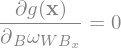

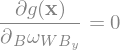

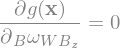

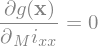

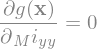

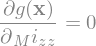

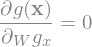

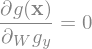

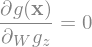

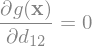

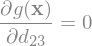

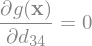

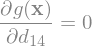

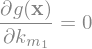

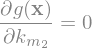

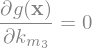

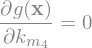

Observable states: 


Unobservable states: 


In [22]:
baro_GNSS_PE.null_calc_opt = "numeric"
baro_GNSS_PE.observable_mode()

# IMU Only Parameter Estimation (PE) Configuration

In [23]:
imu_PE = NOA("IMU Only Parameter Estimation")
imu_PE.x = sp.Matrix([x_T, x_I, x_G])
imu_PE.f = imu_gnss_baro_PE.f
# imu_PE.f


IMU Only Parameter Estimation NOA object initialized


In [24]:
imu_PE.h = h_IMU
imu_PE.LD_order = 2
imu_PE.rank_calc_opt = "numeric"
imu_PE.combn_permn_opt = "drift2ndOrder"
imu_PE.params_config_subs = sp.Matrix([x_T, x_G, x_I, u])
imu_PE.ORC()

Drift 2nd Order Vector Fields
[(0,), (1,), (2,), (3,), (4,)]
current Lie derivative:  k1f0
current Lie derivative:  k1f1
current Lie derivative:  k1f2
current Lie derivative:  k1f3
current Lie derivative:  k1f4
[(0, 1), (0, 2), (0, 3), (0, 4)]
current Lie derivative:  k2f0f1
current Lie derivative:  k2f0f2
current Lie derivative:  k2f0f3
current Lie derivative:  k2f0f4
Substituted parameters with values from same-order prime numbers
printing self.numeric_params_dict:
{{_W{r}_{WB_x}}: 2.3, {_W{r}_{WB_y}}: 7.3, {_W{r}_{WB_z}}: 3.7, {_W{v}_{WB_x}}: 1.39, {_W{v}_{WB_y}}: 1.57, {_W{v}_{WB_z}}: 1.51, q_{WB_w}: 3.1, q_{WB_x}: 6.7, q_{WB_y}: 1.9, q_{WB_z}: 1.1, {_B{\omega}_{WB_x}}: 9.7, {_B{\omega}_{WB_y}}: 7.9, {_B{\omega}_{WB_z}}: 8.9, {\lambda}_l: 4.3, d_{12}: 1.13, d_{23}: 1.27, d_{34}: 7.1, d_{14}: 1.49, k_{f_1}: 2.0, k_{f_2}: 1.03, k_{f_3}: 1.01, k_{f_4}: 1.37, k_{m_1}: 1.3, k_{m_2}: 1.31, k_{m_3}: 1.09, k_{m_4}: 3.0, m: 1.07, {_M{i}_{xx}}: 6.1, {_M{i}_{yy}}: 5.0, {_M{i}_{zz}}: 2.9, {_W{

The observable modes are g(x) which satisfiy these partial differential equations (PDE): 


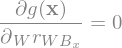

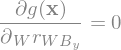

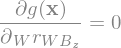

Observable states: 


Unobservable states: 


In [25]:
imu_PE.null_calc_opt = "numeric"
imu_PE.observable_mode()